# Threshold determination analysis

We want to find the optimal threshold for the inclusion probability of SCDCdm.
Benchmark details see paper.

In [14]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az
import os
import pickle as pkl

from scdcdm.util import comp_ana as mod
from scdcdm.util import cell_composition_data as dat
import paper_simulation_scripts.benchmark_utils as util

In [15]:
# Get file names
save_path = "C:\\Users\\Johannes\\Documents\\Uni\\Master's_Thesis\\SCDCdm\\data\\threshold_determination\\threshold_determination_005_balanced\\"
files = os.listdir(save_path)

# Thresholding inclusion probabilities
def recalculate_inc_prob(inc_probs, threshold):
    return [p > threshold for p in inc_probs]

In [16]:
# Prepare output: Dict with one df for each threshold that contains evaluation of all datasets
sim_columns = ['n_cell_types', 'n_cells', 'n_controls',
               'n_cases', 'Base', 'Increase',
               'log-fold increase', 'b_true', 'w_true']

thresholds = np.round(np.arange(0.05, 1., 0.05), 2)

threshold_dict = {}
for t in thresholds:
    threshold_dict[t] = pd.DataFrame(columns=sim_columns + ["threshold", "tp", "tn", "fp", "fn"])

In [17]:
i = 1

# Iterate Over all files
for file in files:
    print(f"file {i}/{len(files)}")
    
    # open file
    with open(save_path + file, "rb") as f:
        d = pkl.load(f)
    
    # For each threshold
    for t in thresholds:
        
        # Prepare df to append to threshold_dict entry
        out_df = d["results"].loc[:, sim_columns]
        out_df["threshold"] = t
        
        tp_list = []
        tn_list = []
        fp_list = []
        fn_list = []
        
        # Iterate over all datasets in file
        for eff in d["effects"]:
            
            # no. of cell types
            K = eff.shape[0]
            ks = list(range(K))[1:]
            
            # calculate significances
            is_significant = recalculate_inc_prob(eff["Inclusion probability"], t)
            
            # Get tp, tn, fp, fn (Truth: Only first cell type significant)
            tp = sum([is_significant[0] == True])
            tp_list.append(tp)
            fn = sum([is_significant[0] == False])
            fn_list.append(fn)
            tn = sum([is_significant[k] == False for k in ks])
            tn_list.append(tn)
            fp = sum([is_significant[k] == True for k in ks])
            fp_list.append(fp)
            
        # add tp, tn, fp, fn to output df
        out_df["tp"] = tp_list
        out_df["tn"] = tn_list
        out_df["fp"] = fp_list
        out_df["fn"] = fn_list
        
        # append to threshold_dict entry
        threshold_dict[t] = threshold_dict[t].append(out_df, ignore_index=True)
        
    i += 1
        

file 1/420
file 2/420
file 3/420
file 4/420
file 5/420
file 6/420
file 7/420
file 8/420
file 9/420
file 10/420
file 11/420
file 12/420
file 13/420
file 14/420
file 15/420
file 16/420
file 17/420
file 18/420
file 19/420
file 20/420
file 21/420
file 22/420
file 23/420
file 24/420
file 25/420
file 26/420
file 27/420
file 28/420
file 29/420
file 30/420
file 31/420
file 32/420
file 33/420
file 34/420
file 35/420
file 36/420
file 37/420
file 38/420
file 39/420
file 40/420
file 41/420
file 42/420
file 43/420
file 44/420
file 45/420
file 46/420
file 47/420
file 48/420
file 49/420
file 50/420
file 51/420
file 52/420
file 53/420
file 54/420
file 55/420
file 56/420
file 57/420
file 58/420
file 59/420
file 60/420
file 61/420
file 62/420
file 63/420
file 64/420
file 65/420
file 66/420
file 67/420
file 68/420
file 69/420
file 70/420
file 71/420
file 72/420
file 73/420
file 74/420
file 75/420
file 76/420
file 77/420
file 78/420
file 79/420
file 80/420
file 81/420
file 82/420
file 83/420
file 84/420
f

In [18]:
# Get scores (mcc, ...) for all thresholds
for k,v in threshold_dict.items():
    print(f"get scores: {k}")
    threshold_dict[k] = util.get_scores(v)

get scores: 0.05
get scores: 0.1
get scores: 0.15
get scores: 0.2
get scores: 0.25
get scores: 0.3
get scores: 0.35
get scores: 0.4
get scores: 0.45
get scores: 0.5
get scores: 0.55
get scores: 0.6
get scores: 0.65
get scores: 0.7
get scores: 0.75
get scores: 0.8
get scores: 0.85
get scores: 0.9
get scores: 0.95


In [19]:
print(threshold_dict[0.3])  

     n_cell_types n_cells n_controls n_cases        Base    Increase  \
0              12    5000          7       7  416.666667  208.333333   
1              12    5000          7       7  416.666667  208.333333   
2              12    5000          7       7  416.666667  208.333333   
3              12    5000          7       7  416.666667  208.333333   
4              12    5000          7       7  416.666667  208.333333   
...           ...     ...        ...     ...         ...         ...   
8395            9    5000          7       7  555.555556  138.888889   
8396            9    5000          7       7  555.555556  138.888889   
8397            9    5000          7       7  555.555556  138.888889   
8398            9    5000          7       7  555.555556  138.888889   
8399            9    5000          7       7  555.555556  138.888889   

      log-fold increase                                             b_true  \
0                  0.58  [-2.485, -2.485, -2.485, -2.485,

In [20]:
total_df = pd.concat(threshold_dict.values(), ignore_index=True)
print(total_df)

       n_cell_types n_cells n_controls n_cases        Base    Increase  \
0                12    5000          7       7  416.666667  208.333333   
1                12    5000          7       7  416.666667  208.333333   
2                12    5000          7       7  416.666667  208.333333   
3                12    5000          7       7  416.666667  208.333333   
4                12    5000          7       7  416.666667  208.333333   
...             ...     ...        ...     ...         ...         ...   
159595            9    5000          7       7  555.555556  138.888889   
159596            9    5000          7       7  555.555556  138.888889   
159597            9    5000          7       7  555.555556  138.888889   
159598            9    5000          7       7  555.555556  138.888889   
159599            9    5000          7       7  555.555556  138.888889   

        log-fold increase                                             b_true  \
0                    0.58  [-2.

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0.30703535 0.43419674 0.51       0.56173068 0.59991668 0.62959482
 0.65351768 0.67333333 0.69009679 0.70451888 0.71709837 0.7281969
 0.73808398 0.74696509]


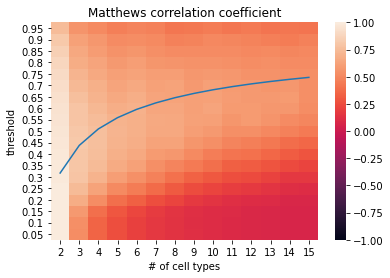

In [21]:
plot_df_mcc = total_df.groupby(["n_cell_types", "threshold"]).agg({"mcc": "mean"}).unstack(level=0)
plot_df_mcc.columns = plot_df_mcc.columns.droplevel(0)

ax = sns.heatmap(data=plot_df_mcc, vmin=-1, vmax=1)
ax.invert_yaxis()

xs = [x+2 for x in range(14)]
ys = 1 - (0.98/np.sqrt(xs))
print(xs)
print(ys)
plt.plot([x+0.5 for x in range(14)], ys*19)

plt.xlabel("# of cell types")
plt.title("Matthews correlation coefficient")

plt.show()

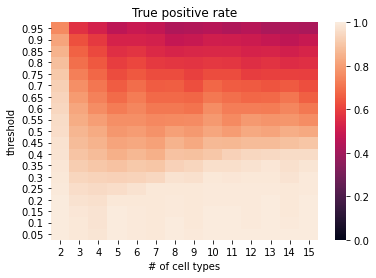

In [22]:
plot_df_tpr = total_df.groupby(["n_cell_types", "threshold"]).agg({"tpr": "mean"}).unstack(level=0)
plot_df_tpr.columns = plot_df_tpr.columns.droplevel(0)

ax = sns.heatmap(data=plot_df_tpr, vmin=0, vmax=1)
ax.invert_yaxis()

plt.xlabel("# of cell types")
plt.title("True positive rate")

plt.show()

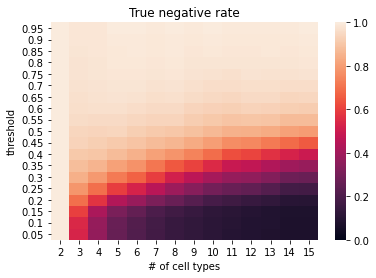

In [23]:
plot_df_tnr = total_df.groupby(["n_cell_types", "threshold"]).agg({"tnr": "mean"}).unstack(level=0)
plot_df_tnr.columns = plot_df_tnr.columns.droplevel(0)

ax = sns.heatmap(data=plot_df_tnr, vmin=0, vmax=1)
ax.invert_yaxis()

plt.xlabel("# of cell types")
plt.title("True negative rate")

plt.show()

In [24]:
int_df = total_df.groupby(["n_cell_types", "threshold"]).agg({"mcc": "mean"})

def interpolate_mcc(thresh, k, int_df):
    residual = (thresh%0.05)
    low_005 = np.round(thresh - residual, 2)
    
    low_mcc = int_df.loc[(k, low_005), :]
    high_mcc = int_df.loc[(k, np.round(low_005 + 0.05, 2)), :]
    
    miss = (high_mcc - low_mcc) * (residual/0.05)
    return (low_mcc + miss).values[0]

In [25]:
cs = np.round(np.arange(0.8, 1.3, 0.01), 2)
ks = [x+2 for x in range(14)]

ssq_mccs = []

for c in cs:
    ys = 1 - (c/np.sqrt(ks))
    mccs = []
    for i in range(14):
        mccs.append(interpolate_mcc(ys[i], ks[i], int_df))
    
    ssq = np.sum([m**2 for m in mccs])
    ssq_mccs.append(ssq)
    
print(ssq_mccs)

[5.920364272541862, 5.94455270315586, 5.968801482614278, 5.993037928368255, 6.016543821969279, 6.040057825977338, 6.062979003423546, 6.084817777882263, 6.106514501039172, 6.128260451818424, 6.149957217866675, 6.172266778851421, 6.194634314547956, 6.216118183535719, 6.237663281855191, 6.259205789040731, 6.277280799822199, 6.294541906348459, 6.311448852128662, 6.3267650090711935, 6.342626621626243, 6.354915040923122, 6.365731411190829, 6.376578274593937, 6.387406169119676, 6.397665618442721, 6.405728698282824, 6.413755978983697, 6.421766876176785, 6.429375661459267, 6.436914273687698, 6.444047896410611, 6.451097603945598, 6.455962250261327, 6.458735001944238, 6.4613601948764705, 6.463999218187799, 6.465364162523434, 6.466576777190851, 6.467802810367157, 6.4664533205405474, 6.464574208153573, 6.458178999326409, 6.449973163094866, 6.440740241114023, 6.431577240478104, 6.422484161187108, 6.410741115388313, 6.396643661337025, 6.382334910330622]


In [26]:
max_c = cs[ssq_mccs.index(np.max(ssq_mccs))]
print(max_c)

1.19
